O problema que temos é realizar a predição do sucesso de um filme. 
Os parâmetros escolhidos para predição de sucesso são **genres** e **original_language**; a métrica de sucesso é o **vote_average**. Não utilizamos dados de orçamento e receita dos filmes porque a maioria desses dados era inválido, fazendo com que se, resolvessemos usar o dataframe resultante, ele seria de pouco mais de 5000 linhas.

O conjunto de dados utilizado foi o [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset). Esses arquivos contêm metadados para todos os 45.000 filmes listados no conjunto de dados Full MovieLens. O conjunto de dados consiste em filmes lançados em ou antes de julho de 2017. Os datasets incluem elenco, equipe, palavras-chave da trama, orçamento, receita, pôsteres, datas de lançamento, idiomas, empresas de produção, países, contagem de votos do TMDB e médias de votos. Para o nosso projeto apenas utilizamos o **movies_metadata**.

O nosso problema é de regressão linear e vamos utilizar uma rede neural artificial com TensorFlow.

In [ ]:
import pathlib

import matplotlib.pyplot as plt
# pndas é uma biblioteca para análise de dados
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import json

In [ ]:
# Lendo o dataset "movies_metadata"
df_movies = pd.read_csv("movies_metadata.csv")

In [ ]:
df_movies['vote_average'].value_counts()

0.0    2998
6.0    2468
5.0    2001
7.0    1886
6.5    1722
       ... 
9.4       3
9.6       1
9.8       1
0.7       1
1.1       1
Name: vote_average, Length: 92, dtype: int64

In [ ]:
# Limpando o dataset "movies_metadata"
df_movies_clean = df_movies[df_movies.status=="Released"]
to_drop = ['adult', 'belongs_to_collection', 'homepage', 'imdb_id', 'overview', 'runtime', 'spoken_languages', 'tagline', 'original_title', 'video', 'vote_count', 'poster_path', 'production_countries', 'popularity', 'budget', 'revenue']
df_movies_clean = df_movies_clean.drop(to_drop, axis=1)
df_movies_clean =  df_movies_clean.replace('[]', np.nan)
df_movies_clean =  df_movies_clean.dropna()
# facilitará as operações matemáticas com id
df_movies_clean =  df_movies_clean.astype({"id": np.int64}, errors='raise')
df_movies_clean =  df_movies_clean.drop_duplicates(subset='id')
# alterando o nome para estar de acordo com o objetivo
df_movies_clean =  df_movies_clean.rename(columns = {"release_date":"release_year"})
# apagando os caracteres que não importam no que diz respeito a data, ou seja, está deixando apenas o ano
df_movies_clean.release_year =  df_movies_clean.release_year.str[0:4]
# alterando o tipo do ano
df_movies_clean =  df_movies_clean.astype({"release_year": np.int64}, errors='raise')
df_movies_clean

,genres,id,original_language,production_companies,release_year,status,title,vote_average
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,"[{'name': 'Pixar Animation Studios', 'id': 3}]",1995,Released,Toy Story,7.7
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",1995,Released,Jumanji,6.9
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",1995,Released,Grumpier Old Men,6.5
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,[{'name': 'Twentieth Century Fox Film Corporat...,1995,Released,Waiting to Exhale,6.1
4,"[{'id': 35, 'name': 'Comedy'}]",11862,en,"[{'name': 'Sandollar Productions', 'id': 5842}...",1995,Released,Father of the Bride Part II,5.7
...,...,...,...,...,...,...,...,...
45458,"[{'id': 27, 'name': 'Horror'}]",289923,en,"[{'name': 'Neptune Salad Entertainment', 'id':...",2000,Released,The Burkittsville 7,7.0
45459,"[{'id': 878, 'name': 'Science Fiction'}]",222848,en,"[{'name': 'Concorde-New Horizons', 'id': 4688}]",1995,Released,Caged Heat 3000,3.5
45460,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",30840,en,"[{'name': 'Westdeutscher Rundfunk (WDR)', 'id'...",1991,Released,Robin Hood,5.7
45462,"[{'id': 18, 'name': 'Drama'}]",111109,tl,"[{'name': 'Sine Olivia', 'id': 19653}]",2011,Released,Century of Birthing,9.0


<function matplotlib.pyplot.show>

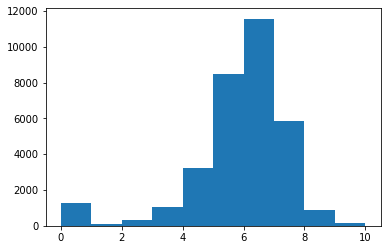

In [ ]:
# Visualizando o histograma da média de votos
plt.hist(df_movies_clean['vote_average'])
plt.show

In [ ]:
to_drop2 = ['status','release_year', 'title', 'id', 'production_companies']
# por enquanto, aqui temos a base de dados sem as colunas acima
df_movies_rna = df_movies_clean.drop(to_drop2, axis=1)
df_movies_rna

,genres,original_language,vote_average
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,7.7
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,6.9
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",en,6.5
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,6.1
4,"[{'id': 35, 'name': 'Comedy'}]",en,5.7
...,...,...,...
45458,"[{'id': 27, 'name': 'Horror'}]",en,7.0
45459,"[{'id': 878, 'name': 'Science Fiction'}]",en,3.5
45460,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",en,5.7
45462,"[{'id': 18, 'name': 'Drama'}]",tl,9.0


In [ ]:
# get_dummies no panda retorna uma tabela que representará de maneira binária (0 ou 1) a lista, por exemplo: list(a,b,c) - (pós get_dummies) - https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
original_language_df=pd.get_dummies(df_movies_rna['original_language'], prefix='original_language')
genres_df= pd.get_dummies(df_movies_rna['genres'], prefix='genres')
#production_comp_df= pd.get_dummies(df_movies_rna['production_companies'], prefix='production_companies')
# juntará todas as tabelas
df_movies_rna = pd.concat([df_movies_rna,original_language_df, genres_df], axis='columns')

df_movies_rna=  df_movies_rna.drop(['original_language', 'genres'], axis=1)
df_movies_rna

,vote_average,original_language_ab,original_language_af,original_language_am,original_language_ar,original_language_ay,original_language_bg,original_language_bm,original_language_bn,original_language_bo,...,"genres_[{'id': 99, 'name': 'Documentary'}, {'id': 36, 'name': 'History'}, {'id': 10770, 'name': 'TV Movie'}]","genres_[{'id': 99, 'name': 'Documentary'}, {'id': 36, 'name': 'History'}, {'id': 53, 'name': 'Thriller'}]","genres_[{'id': 99, 'name': 'Documentary'}, {'id': 36, 'name': 'History'}]","genres_[{'id': 99, 'name': 'Documentary'}, {'id': 53, 'name': 'Thriller'}]","genres_[{'id': 99, 'name': 'Documentary'}, {'id': 80, 'name': 'Crime'}]","genres_[{'id': 99, 'name': 'Documentary'}, {'id': 878, 'name': 'Science Fiction'}]","genres_[{'id': 99, 'name': 'Documentary'}, {'id': 9648, 'name': 'Mystery'}, {'id': 10769, 'name': 'Foreign'}]","genres_[{'id': 99, 'name': 'Documentary'}, {'id': 9648, 'name': 'Mystery'}, {'id': 36, 'name': 'History'}, {'id': 80, 'name': 'Crime'}]","genres_[{'id': 99, 'name': 'Documentary'}, {'id': 9648, 'name': 'Mystery'}]","genres_[{'id': 99, 'name': 'Documentary'}]"
0,7.7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6.9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6.5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6.1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5.7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45458,7.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45459,3.5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45460,5.7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45462,9.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# captura uma quantia aleatória dos dados, no caso, 80%
train_dataset = df_movies_rna.sample(frac=0.8,random_state=0)

# definindo o dataset(base de dados) teste, no caso, os 20% que sobrou.
test_dataset = df_movies_rna.drop(train_dataset.index)

In [ ]:
test_dataset

In [ ]:
# retira do "train_dataset" o "vote_average" e aplica a variável etc.
train_labels = train_dataset.pop('vote_average')
test_labels = test_dataset.pop('vote_average')


In [ ]:
# describe() retorna uma coluna com dados estatísticos 
train_stats = train_dataset.describe()
#train_stats.pop('vote_average')
# transpose() inverte a coluna, as linhas tornam-se colunas e colunas em linhas
train_stats = train_stats.transpose()
train_stats


In [ ]:
def build_model():
    # o sequantial define um conjunto de camadas sequenciais de perceptors  
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])
    optimizer = tf.keras.optimizers.Adam(0.001) #Adam é melhor para problemas com uma grande quantidade de dados
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    # modelo de aprendizagem de máquina  
    return model

In [ ]:
# chama a função que retorna o modelo e imprime o modelo
model=build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                237184    
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 241,409
Trainable params: 241,409
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS = 4
history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2)

Epoch 1/4
661/661 [==============================] - 5s 8ms/step - loss: 2.0167 - mae: 0.9148 - mse: 2.0167 - val_loss: 2.8371 - val_mae: 1.1283 - val_mse: 2.8371
Epoch 2/4
661/661 [==============================] - 4s 6ms/step - loss: 2.0133 - mae: 0.9163 - mse: 2.0133 - val_loss: 2.8886 - val_mae: 1.1315 - val_mse: 2.8886
Epoch 3/4
661/661 [==============================] - 4s 5ms/step - loss: 2.0169 - mae: 0.9145 - mse: 2.0169 - val_loss: 2.8198 - val_mae: 1.1466 - val_mse: 2.8198
Epoch 4/4
661/661 [==============================] - 3s 5ms/step - loss: 2.0048 - mae: 0.9114 - mse: 2.0048 - val_loss: 2.8176 - val_mae: 1.1417 - val_mse: 2.8176


In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,2.016684,0.914801,2.016684,2.837052,1.128333,2.837052,0
1,2.013252,0.916344,2.013252,2.888608,1.131476,2.888608,1
2,2.016934,0.914522,2.016934,2.819789,1.146581,2.819789,2
3,2.004846,0.911396,2.004846,2.817639,1.141675,2.817639,3


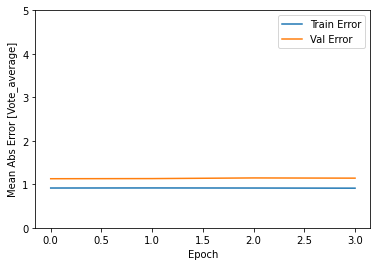

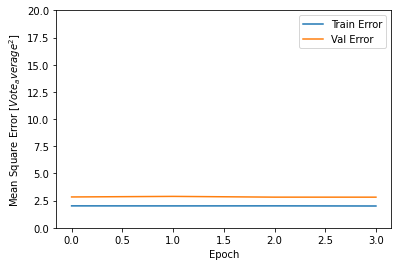

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Vote_average]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Vote_average^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

In [ ]:
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:6.2f} vote_average".format(mae))

207/207 - 0s - loss: 2.8139 - mae: 1.1496 - mse: 2.8139 - 397ms/epoch - 2ms/step
Testing set Mean Abs Error:   1.15 vote_average


In [ ]:
def round_list(generic_list):
  for i in range(len(generic_list)):
    generic_list[i]=round(generic_list[i],2)
  return generic_list

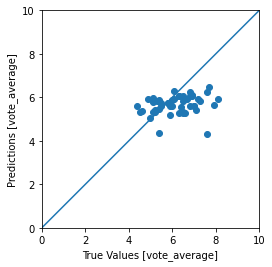

In [ ]:
test_predictions = model.predict(test_dataset).flatten()
test_predictions=round_list(test_predictions)
plt.scatter(test_labels[:50], test_predictions[:50])
plt.xlabel('True Values [vote_average]')
plt.ylabel('Predictions [vote_average]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,10])
plt.ylim([0,10])
_ = plt.plot([-100, 100], [-100, 100])

In [ ]:
test_labels_nump=test_labels.to_numpy()
# for i in range(len(test_predictions)):
#   if test_predictions[i]>=8:
#     print(i)
print(test_labels_nump[3020])
print(test_predictions[3020])


7.5
8.26


<function matplotlib.pyplot.show>

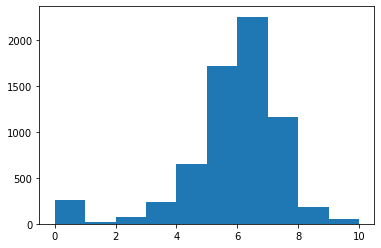

In [ ]:
plt.hist(test_labels)
plt.show

<function matplotlib.pyplot.show>

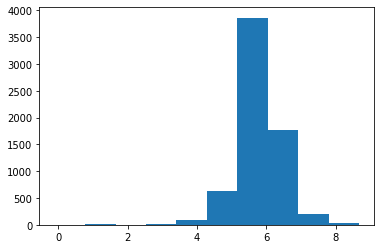

In [ ]:
plt.hist(test_predictions)
plt.show

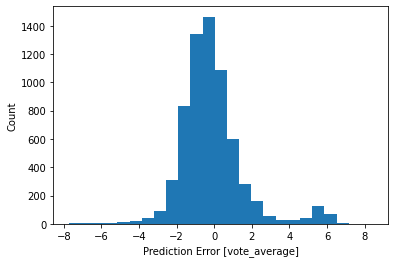

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [vote_average]")
_ = plt.ylabel("Count")